In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))

import CtllDes 
from CtllDes.core import ctll, satellite


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy as astr
import astropy.units as u
import astropy

In [3]:
from poliastro.bodies import Earth, Sun
from poliastro.frames import Planes
from poliastro.constants import J2000
from poliastro.ephem import Ephem

# Define a function using poliastro utilities in order to obtain the sun-earth vector
this could be added to the library if needed, but I don't think is appropriate since every utility comes from poliastro and astropy libraries.

# Defining specifications and parameters constraints

## <strong>Instruments</strong>

In [4]:
import CtllDes.core.instrument as instr

In [5]:
ROLL_ANGLE = 30*u.deg

### 1st instrument

In [6]:
pixel_width_1 = 28*1E-6*u.m
n_pixels_1 = 3072
sensor_width_1 = n_pixels_1*pixel_width_1
f_length_1 = 17*1E-2*u.m

In [7]:
instr_1 = instr.RollCamera(f_length_1, sensor_width_1, ROLL_ANGLE)

### 2nd instrument 

In [8]:
pixel_width_2 = 7*1E-6*u.m
n_pixels_2 = 12288
sensor_width_2 = n_pixels_2*pixel_width_2
f_length_2 = 4.2*u.m

In [9]:
instr_2 = instr.RollCamera(f_length_2, sensor_width_2, ROLL_ANGLE)

## <strong>Targets</strong>

In [10]:
from CtllDes.targets.targets import Target, Targets

### 1st instrument targets

In [11]:
bs_as = Targets.from_state("Buenos Aires", N=8)
rio_negro = Targets.from_state("Río Negro", N=11)

### 2nd instrument targets

In [12]:
gba = Targets.from_state("Ciudad de Buenos Aires", N=8) 
cordoba_city = Target.from_city('Córdoba',country='AR')
rosario_city = Target.from_city('Rosario',country='AR')

### <strong>Ground Stations</strong>

In [13]:
MIN_ELEVATION = 15*u.deg
DOWN_RATE = 300*1E6*u.bit/u.s

In [14]:
gs_1 = Target(-64.45, -31.58333)
gs_2 = Target(-58.718, -34.411)

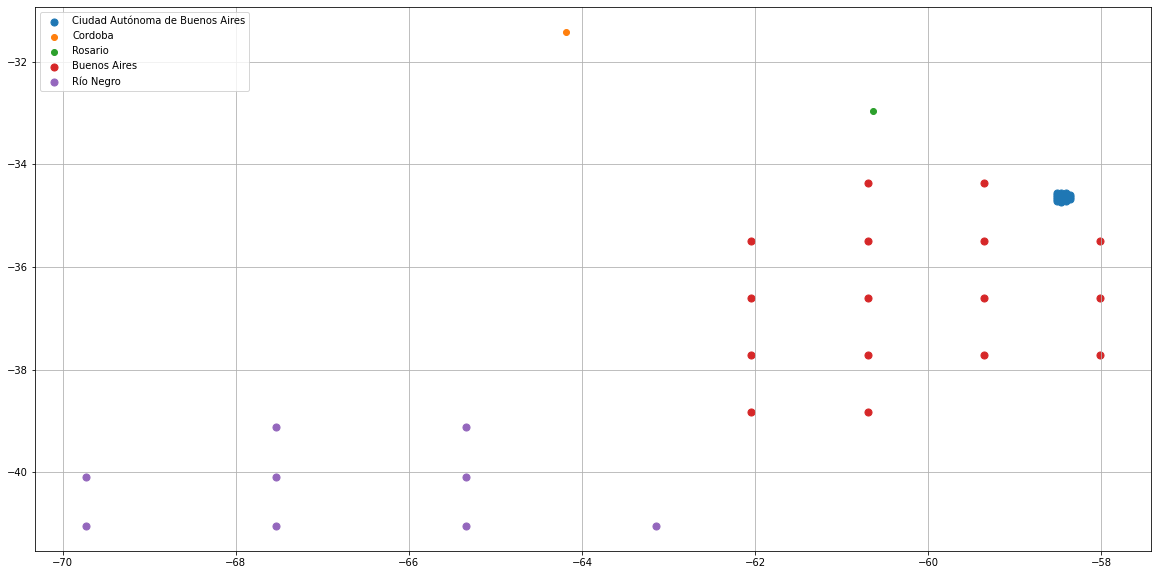

In [15]:
fig = plt.figure(figsize=(20,10))
plt.grid()

plt.scatter(gba.lons,gba.lats,s=50,label='Ciudad Autónoma de Buenos Aires')
plt.scatter(cordoba_city.lon,cordoba_city.lat,label='Cordoba')
plt.scatter(rosario_city.lon,rosario_city.lat,label='Rosario')


plt.scatter(bs_as.lons,bs_as.lats,s=50,label='Buenos Aires')
plt.scatter(rio_negro.lons,rio_negro.lats,s=50,label='Río Negro')

plt.legend(loc=2)

### <strong>Orbits</strong>

In [16]:
H_MIN = 550*u.km
H_MAX = 650*u.km
MAX_INC = 45*u.deg

R = Earth.R_mean.to(u.km)

R_MIN = R + H_MIN
R_MAX = R + H_MAX

In [17]:
from CtllDes.utils import sscalc

D = 3 #days for revisit
orb_df = sscalc.helio_rgt_synchronous(D) #dataframe
orb_df.head() #radius [km], inclination [degrees], revolutions per day.

,radius,inc,N
0,11549.628629,142.101524,7.000000
1,11196.684826,135.067101,7.333333
2,10869.554031,129.657165,7.666667
3,10565.337007,125.300767,8.000000
4,10281.565346,121.693395,8.333333


In [18]:
filtered_orbits  = orb_df.loc[(orb_df['radius'] > R_MIN.value) & (orb_df['radius'] < R_MAX.value)]
filtered_orbits

,radius,inc,N
24,6947.854468,97.66328,15.0


### Extract semi major axis length = to radius, and inclination.

In [19]:
a = filtered_orbits['radius'].values[0]
a *= u.km
a

<Quantity 6947.85446754 km>

In [20]:
inc = filtered_orbits['inc'].values[0]
inc *= u.deg
inc

<Quantity 97.66328018 deg>

### Define the rest of the classical orbit parameters

In [21]:
ecc = 0*u.one
raan = 0*u.deg # right ascencion of the ascending node [angle]
argp = 0*u.rad # perigee argument [angle]
nu = 0*u.deg # true anomaly [angle] defined as -180 so that it coincides with LTDN

### Build orbit

In [22]:
from poliastro.twobody import Orbit

orb = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            raan,
                            argp,
                            nu)

In [23]:
print(orb.r)
print(orb.v)

[6947.85446754    0.            0.        ] km
[ 0.         -1.01004329  7.50667069] km / s


In [24]:
sat = satellite.Sat.from_orbit(orb)

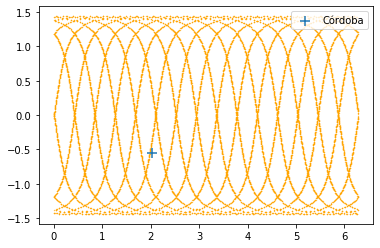

In [25]:
r,v = sat.rv(10,dt=50,J2=True)
lon,lat = sat.ssps_from_r(r,10,dt=50,J2=True)
plt.scatter(lon,lat,s=0.1,c='orange')
plt.scatter(cordoba_city.lon*u.deg.to(u.rad) + 180*u.deg.to(u.rad), cordoba_city.lat*u.deg.to(u.rad),marker='+',label='Córdoba',s=100)
plt.legend(loc=1)

Lets redefine the angle such that LTDN is 12 o'clock solar time 

In [26]:
from CtllDes.utils import trigsf, angles

today = astropy.time.Time({'year': 2021, 'month': 12, 'day': 31,'hour': 12, 'minute': 0, 'second': 0}, scale='utc')
earth_orb = Ephem.from_body(Sun, today.tdb, attractor=Earth)
r0_sun = earth_orb.rv()[0][0].to(u.km)
rr0_sun, lat0_sun, lon0_sun = trigsf.c2s(r0_sun[0],r0_sun[1],r0_sun[2])
lon0_sun.to(u.deg)

<Quantity -79.42945987 deg>

### So the initial raan of the satellite orbit must be such that when $\theta_p+\nu=180\text{°}$ the longitude value in the inertial reference frame is exactly the same as the sun. Therefore

In [27]:
argp = 0*u.deg
nu = 180*u.deg - argp

orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
r0_sat = orb.r
rr0_sat, lat0_sat, lon0_sat = trigsf.c2s(r0_sat[0],r0_sat[1],r0_sat[2])
lon0_sat.to(u.deg)

/home/vancii/.local/lib/python3.8/site-packages/astropy/units/decorators.py:251: UserWarning: Wrapping true anomaly to -π <= nu < π
  return_ = wrapped_function(*func_args, **func_kwargs)


<Quantity 180. deg>

### Naturally the initial longitude, if raan is 0 must be the exactly $\nu$, therefore modifying raan by $lon(sun_0)-180°$ we get

In [28]:
raan = lon0_sun-180*u.deg
orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
new_r0_sat = orb.r
_, _, lon0_sat = trigsf.c2s(new_r0_sat[0],new_r0_sat[1],new_r0_sat[2])
lon0_sat.to(u.deg)

<Quantity -79.42945987 deg>

In [39]:
#this has to change names, is not passage raan, is passage offset. 
cordoba_offset = angles.get_passage_raan(sat, (cordoba_city.lon*u.deg).to(u.rad),(cordoba_city.lat*u.deg).to(u.rad))

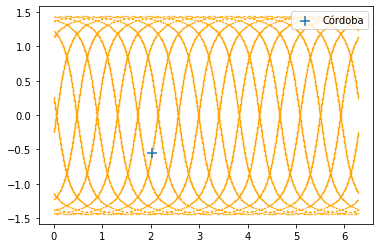

In [41]:
sat = satellite.Sat.from_orbit(orb)
r,v = sat.rv(11,dt=50,J2=True)
lon,lat = sat.ssps_from_r(r,11,dt=50,lon_offset=cordoba_offset,J2=True)
plt.scatter(lon,lat,s=0.1,c='orange')
plt.scatter(cordoba_city.lon*u.deg.to(u.rad) + 180*u.deg.to(u.rad), cordoba_city.lat*u.deg.to(u.rad),marker='+',label='Córdoba',s=100)
plt.legend(loc=1)

## Definitive first reference sat

In [42]:
ctll_hrgt = ctll.Ctll.from_WalkerDelta(4, 1, 0, orb.a, orb.ecc, orb.inc, orb.argp, raan_offset=orb.raan, nu_offset=nu, instruments=instr_1)

In [43]:
from CtllDes.requests.coverage import Coverages 

## Define time of study and time interval, i.e T=10, dt=20

In [44]:
T=10
ti=20

In [34]:
from CtllDes.utils import sunearth
rsun = sunearth.bodies_vector(T, ti, Earth, Sun, epoch=today)

### Instrument 1 targets, that is Buenos Aires and Río Negro.

In [ ]:
cov_cordoba = Coverages.from_ctll(ctll_hrgt, cordoba_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

In [46]:
cov_cordoba.to_df()

,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-64.1833, -31.4167)",1600,160.000000,78400.000000,42826.368519,85632.774074,86240,"[0.40282662371844136 rad, 0.3811927262223308 r..."
1,10,20,505f3616-9651-4975-8510-11eb68988dc4,"(-64.1833, -31.4167)",1400,127.272727,71883.333333,38987.940278,77955.912963,87680,"[1.171790948548558 rad, 1.1935950432498674 rad..."
2,10,20,c5aa1cff-0c37-4c2a-9a51-1666094828af,"(-64.1833, -31.4167)",1680,168.000000,78392.727273,40885.384722,81750.808333,86220,"[2.738766029871352 rad, 2.760399927362437 rad,..."
3,10,20,b9ab93c5-062d-43a3-a277-2652239728e6,"(-64.1833, -31.4167)",1480,134.545455,71876.666667,42866.380093,85712.794444,127660,"[1.9698017050412353 rad, 1.9479976103305847 ra..."


In [70]:
filtered_cov_cordoba = cov_cordoba.filter_by_sun_angle(np.pi/4)
filtered_cov_cordoba.to_df()

,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-64.1833, -31.4167)",0,0.0,864000.000000,432010.000000,864000.000000,864000,"[0.40282662371844136 rad, 0.3811927262223308 r..."
1,10,20,505f3616-9651-4975-8510-11eb68988dc4,"(-64.1833, -31.4167)",180,90.0,287940.000000,316749.768519,633479.541204,733420,"[1.171790948548558 rad, 1.1935950432498674 rad..."
2,10,20,c5aa1cff-0c37-4c2a-9a51-1666094828af,"(-64.1833, -31.4167)",1680,168.0,78392.727273,40885.384722,81750.808333,86220,"[2.738766029871352 rad, 2.760399927362437 rad,..."
3,10,20,b9ab93c5-062d-43a3-a277-2652239728e6,"(-64.1833, -31.4167)",1260,140.0,86274.000000,45189.696296,90359.421759,127660,"[1.9698017050412353 rad, 1.9479976103305847 ra..."


In [85]:
cov_rosario = Coverages.from_ctll(ctll_hrgt, rosario_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset)
cov_rosario.to_df()

Satellite 1 of 4


target -60.64° -32.96°. 1 of 1
Satellite 2 of 4
target -60.64° -32.96°. 1 of 1
Satellite 3 of 4
target -60.64° -32.96°. 1 of 1
Satellite 4 of 4
target -60.64° -32.96°. 1 of 1


,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-60.6394, -32.9575)",1840,131.428571,57477.333333,34422.767593,68825.577778,86300,"[0.40282662371844136 rad, 0.38119385000034883 ..."
1,10,20,505f3616-9651-4975-8510-11eb68988dc4,"(-60.6394, -32.9575)",1740,124.285714,57484.000000,34503.519444,68987.079167,86320,"[1.171790948548558 rad, 1.193595880193208 rad,..."
2,10,20,c5aa1cff-0c37-4c2a-9a51-1666094828af,"(-60.6394, -32.9575)",1140,126.666667,95873.333333,58044.725926,116069.478241,215020,"[2.738766029871352 rad, 2.760398803594732 rad,..."
3,10,20,b9ab93c5-062d-43a3-a277-2652239728e6,"(-60.6394, -32.9575)",1200,133.333333,86280.000000,57971.216667,115922.461111,215000,"[1.9698017050412353 rad, 1.947996773399435 rad..."


In [89]:
cov_rosario_filtered = cov_rosario.filter_by_sun_angle(np.pi/4).collapse_sats()
cov_rosario_filtered.to_df()

,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,10,20,,"(-60.6394, -32.9575)",2860,130.0,37440.869565,39214.904167,78409.874537,84880,None


In [ ]:
cov_baires_ctll_hrgt = Coverages.from_ctll(ctll_hrgt, bs_as, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

In [50]:
cov_baires_ctll_hrgt.to_df().head()

,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-62.04402324091975, -38.8197478163978)",1600,160.000000,78400.000000,42837.740741,85655.518519,86240,"[0.40282662371844136 rad, 0.3811927262223308 r..."
1,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-60.6992338529398, -38.8197478163978)",2040,107.368421,43098.000000,23663.189815,47306.426852,84180,"[0.40282662371844136 rad, 0.3811927262223308 r..."
2,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-62.04402324091975, -37.70711313209672)",1640,164.000000,78396.363636,42831.850463,85643.738889,86240,"[0.40282662371844136 rad, 0.3811927262223308 r..."
3,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-60.6992338529398, -37.70711313209672)",1620,147.272727,71865.000000,40707.481944,81395.001389,86240,"[0.40282662371844136 rad, 0.3811927262223308 r..."
4,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-59.354444464959855, -37.70711313209672)",2560,128.000000,41020.952381,21603.354167,43186.767593,47600,"[0.40282662371844136 rad, 0.3811927262223308 r..."


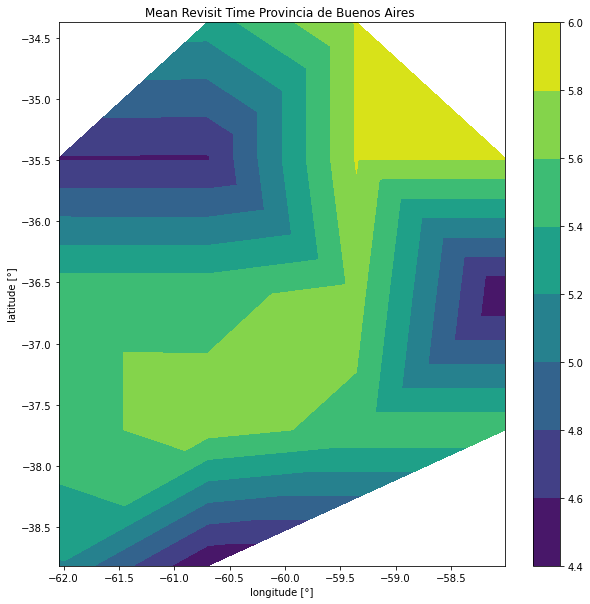

In [90]:
plot_Targets_merit(cov_baires_ctll_hrgt.collapse_sats().to_df(), bs_as, target_name = 'Provincia de Buenos Aires', accumulated=False, response=False,
                  average_time_gap=False)

In [54]:
new_baires = cov_baires_ctll_hrgt.filter_by_sun_angle(np.pi/4)

In [55]:
new_baires.to_df().head()

,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-62.04402324091975, -38.8197478163978)",0,0.000000,864000.000000,432010.000000,864000.000000,864000,"[0.40282662371844136 rad, 0.3811927262223308 r..."
1,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-60.6992338529398, -38.8197478163978)",380,42.222222,86362.000000,45567.081019,91114.170833,131920,"[0.40282662371844136 rad, 0.3811927262223308 r..."
2,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-62.04402324091975, -37.70711313209672)",0,0.000000,864000.000000,432010.000000,864000.000000,864000,"[0.40282662371844136 rad, 0.3811927262223308 r..."
3,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-60.6992338529398, -37.70711313209672)",20,20.000000,431990.000000,392990.859259,785961.718981,823040,"[0.40282662371844136 rad, 0.3811927262223308 r..."
4,10,20,39e95b77-935c-4824-b9d9-2d4afd5569a6,"(-59.354444464959855, -37.70711313209672)",900,90.000000,78463.636364,40965.220833,81910.462500,86320,"[0.40282662371844136 rad, 0.3811927262223308 r..."


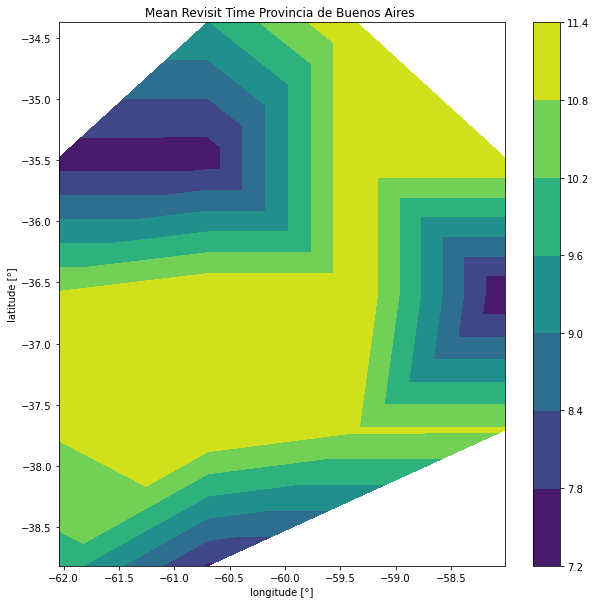

In [91]:
plot_Targets_merit(new_baires.collapse_sats().to_df(), bs_as, target_name = 'Provincia de Buenos Aires', accumulated=False, response=False,
                  average_time_gap=False)

In [ ]:
cov_rio_negro_ctll_hrgt = Coverages.from_ctll(ctll_hrgt, rio_negro, T, dt=ti, r_sun=rsun, J2=True)

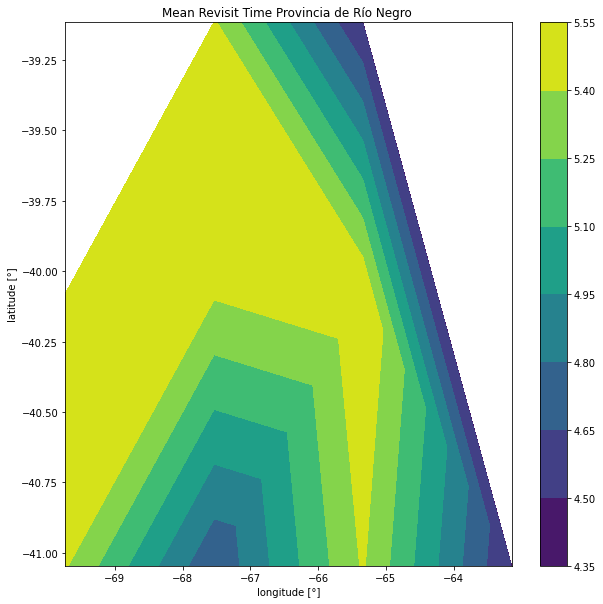

In [58]:
plot_Targets_merit(cov_rio_negro_ctll_hrgt.collapse_sats().to_df(), rio_negro, target_name = 'Provincia de Río Negro', accumulated=False, response=False,
                  average_time_gap=False)

In [ ]:
cov_gba = Coverages.from_ctll(ctll_hrgt, gba, T, ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

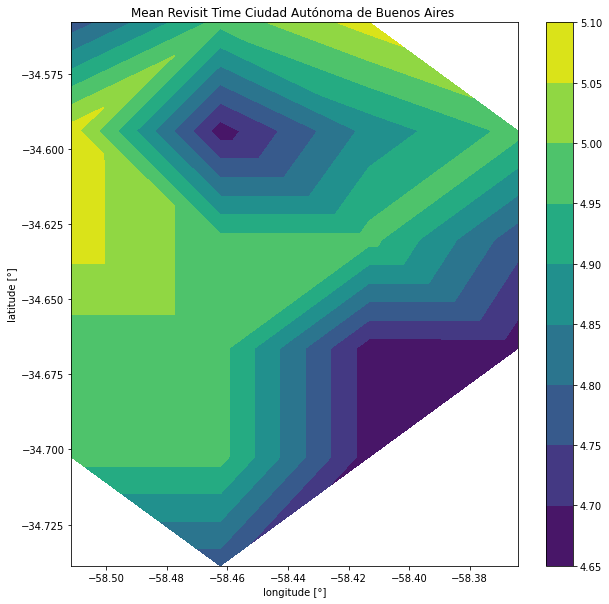

In [66]:
plot_Targets_merit(cov_gba.collapse_sats().to_df(), gba, target_name='Ciudad Autónoma de Buenos Aires',
                  response=False, average_time_gap=False,accumulated=False)

In [61]:
cov_gba_filtered = cov_gba.filter_by_sun_angle(np.pi/4)

In [62]:
collapsed_cov_gba = cov_gba_filtered.collapse_sats().to_df()

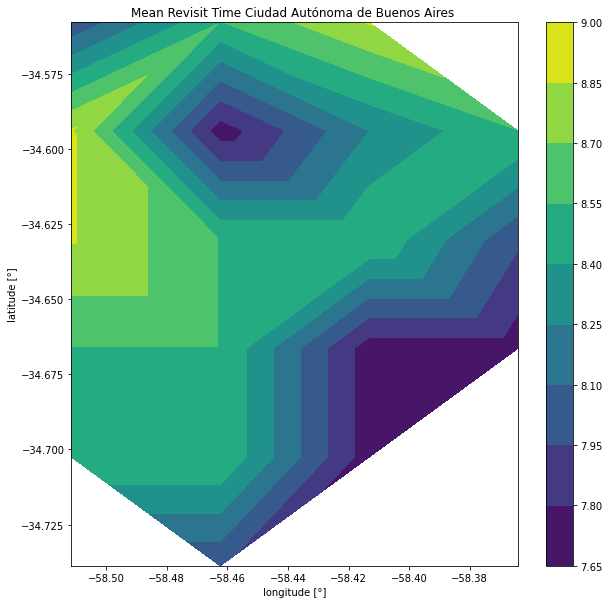

In [67]:
plot_Targets_merit(collapsed_cov_gba, gba, target_name='Ciudad Autónoma de Buenos Aires',
                  response=False, average_time_gap=False, accumulated=False)

In [97]:
test_cov = cov_rosario_filtered.covs[0]


In [142]:
from itertools import groupby
import time

test_cov_rle = np.array([[k, sum(1 for i in g)] for k,g in groupby(test_cov.cov)])
t = time.time()
gap = 0

for i in test_cov_rle:
    if i[0] == 0:
        gap+=0
    else:
        pass
        
print(f"Took {time.time()-t} seconds")
test_cov_rle

Took 0.0008215904235839844 seconds


array([[   0, 2113],
       [   1,    8],
       [   0,   64],
       [   1,    6],
       [   0, 4176],
       [   1,    2],
       [   0,   66],
       [   1,    8],
       [   0,   65],
       [   1,    4],
       [   0, 4176],
       [   1,    5],
       [   0,   64],
       [   1,    8],
       [   0, 4244],
       [   1,    7],
       [   0,   64],
       [   1,    8],
       [   0, 4243],
       [   1,    8],
       [   0,   63],
       [   1,    8],
       [   0, 4243],
       [   1,    8],
       [   0,   64],
       [   1,    6],
       [   0, 4176],
       [   1,    3],
       [   0,   65],
       [   1,    9],
       [   0,   65],
       [   1,    4],
       [   0, 4175],
       [   1,    5],
       [   0,   65],
       [   1,    8],
       [   0, 4244],
       [   1,    6],
       [   0,   64],
       [   1,    8],
       [   0, 4244],
       [   1,    7],
       [   0,   64],
       [   1,    7],
       [   0, 2250]])

In [65]:
def plot_Targets_merit(rollcovdf, tgts, target_name = 'Not specified', accumulated=True, response=True, average_time_gap=True, revisit=True, use_3d = False):
    
    target_lons = tgts.lons
    target_lats = tgts.lats

    roll_accum = rollcovdf['accumulated'].to_numpy(dtype=float)/3600
    #roll_accum /= max(roll_accum)

    response_time = rollcovdf['response time'].to_numpy()/3600
    response_time = 1/response_time
    response_time -= min(response_time)
    response_time /= max(response_time)
        
    roll_avg = rollcovdf['average time gap'].to_numpy(dtype=float)/3600
    roll_avg = 1/roll_avg
    roll_avg -= min(roll_avg)
    roll_avg /= max(roll_avg) 
    
    revisit_time = rollcovdf['mean gap dark'].to_numpy(dtype=np.float64)/3600
        
    if accumulated:
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax.plot_trisurf(target_lons, target_lats, roll_accum,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, roll_accum)
            plt.colorbar(tcs)

        
        ax.set_title(f"Accumulated time of view for {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.set_zlabel("Accumulated time of view [hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))


        
    if response:
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.plot_trisurf(target_lons, target_lats, response_time,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, response_time)
            plt.colorbar(tcs)
            
        ax.set_title(f"Response Time for {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax.set_zlabel("Respose time [1/hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))
        

        
    if average_time_gap:        
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.plot_trisurf(target_lons, target_lats, roll_avg,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, roll_avg)
            plt.colorbar(tcs)

        ax.set_title(f"Average time Gap for {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax.set_zlabel("Average time Gap for [1/hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))
        

       
    if revisit:
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.plot_trisurf(target_lons, target_lats, revisit_time,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, revisit_time)
            plt.colorbar(tcs)
        
        ax.set_title(f"Mean Revisit Time {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax.set_zlabel("Mean Revisit Time [hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))

